### Imports

In [389]:
import numpy as np
import pandas as pd 
from collections import Counter
import os
import glob
import copy
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn import metrics
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from matplotlib.backends.backend_pdf import PdfPages
import math
from matplotlib.lines import Line2D
import umap.umap_ as umap
from combat.pycombat import pycombat

### Read batch effect corrected files (GMM and K-Means)

In [390]:
gmm_corrected = pd.read_csv("../backup/batch_effect_corrected_dfs/gmm.csv", index_col=0)
km_corrected = pd.read_csv("../backup/batch_effect_corrected_dfs/km.csv", index_col=0)

In [391]:
def atn_based_df(df, method):
    """df: batch effect corrected dataframe that contain all the selected cohorts and their ATN stages
       method: the method that was used for extracting the threshlods.
       
       This function performs hierarchical clustering for different number of clusters. The number of cluster
       with maximum silhouette score is then seleted. The function will return the final labels (based on the number
       of cluster selected by the silhouette score), a dictionary of dataframes where the keys are the ATN stage and
       values are dfs (measurements of participants within that stage) and a df containing the silhouette score for 
       each atn stage with different number of clusters.
       
       Note: we only select the ATN categories with minimum 20 participants"""
    
    labels_atn = dict()
    labels_atn_2 = dict()

    
    # change the cohort names to int and write in a column
    for i, j in zip(df.Cohort.unique(), range(len(df.Cohort.unique()))):
        df.loc[df['Cohort']==i, 'Cohort_number'] = j
    
    # select the profiles that have over 20 participants
    # make a dictionary where the selcted ATN profiles are key and 
    # the subset of dataframe categorized in that ATN profile is value
    dfs_sub = {atn: df.loc[df.ATN==atn].copy() for atn in list((a) for a,b in dict(Counter(df.ATN)).items() if b >20)}
    
    # make a dataframe to store the silhouette scores for each atn category and different number of clusters 
    silho_score = pd.DataFrame(index=gmm_corrected.ATN.unique(), columns=[i for i in range(2,9)])
    
    for i in dfs_sub:
        
        for n_k in range(2, 9):
            hierarchical_cluster = AgglomerativeClustering(n_clusters=n_k, affinity='euclidean', linkage='ward')
            labels = hierarchical_cluster.fit_predict(dfs_sub[i][dfs_sub[i].columns.difference(['ATN', 'Cohort', 'Cohort_number'])])
            labels_atn[i] = labels
            silho_score.loc[i, n_k] = metrics.silhouette_score(dfs_sub[i][dfs_sub[i].columns.difference(['ATN', 'Cohort', 'Cohort_number'])], labels_atn[i])

        silho_max = dict(silho_score.dropna().astype(float).idxmax(axis=1))
        
        hierarchical_cluster_2 = AgglomerativeClustering(n_clusters=len(dfs_sub[i].Cohort.unique()), affinity='euclidean', linkage='ward')
        labels = hierarchical_cluster_2.fit_predict(dfs_sub[i][dfs_sub[i].columns.difference(['ATN', 'Cohort', 'Cohort_number'])])
        labels_atn_2[i] = labels        
        
        
    fig, axes = plt.subplots(1, 1, figsize=(10, 6))

    # plot the silhouette score against different k
    for ind in silho_score.index.dropna():
        
        silho_score.loc[ind].plot(ax=axes)
        axes.legend()
        axes.set_title(method)
        axes.set_ylabel("Silhoutte score")
        axes.set_xlabel("Number of cluster")
            
    return labels_atn_2, dfs_sub, silho_score

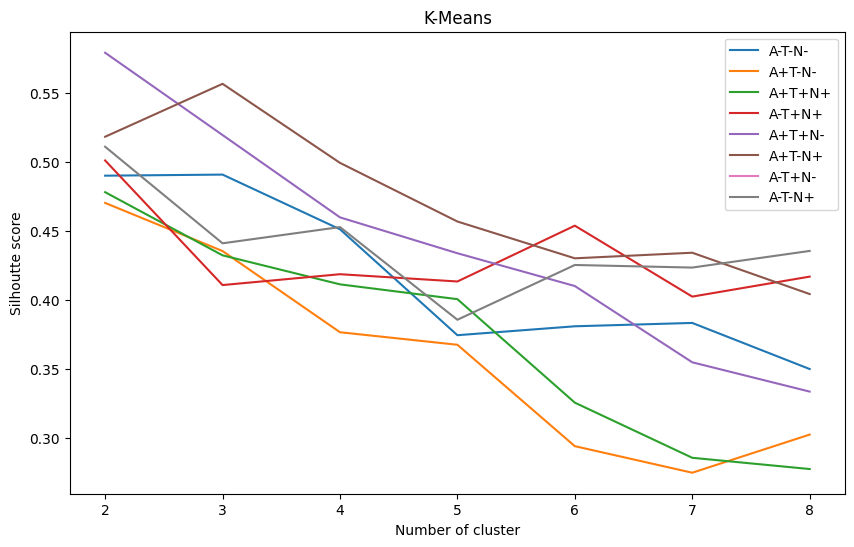

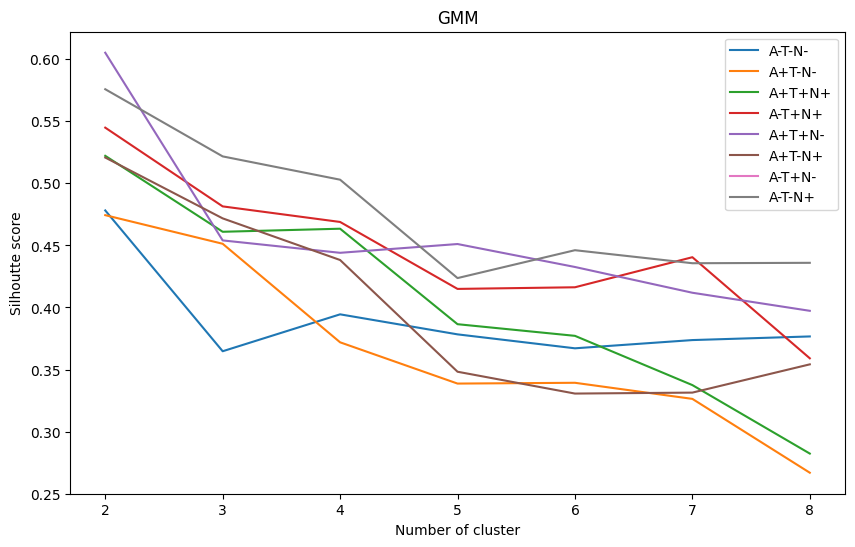

In [392]:
labels_km, atn_km_df, silho_km = atn_based_df(km_corrected, "K-Means")
labels_gmm, atn_gmm_df, silho_gmm = atn_based_df(gmm_corrected, "GMM")

In [393]:
for i in labels_km:
    atn_km_df[i].loc[:, 'predicted_cohort'] = list(labels_km[i])

for i_ in labels_gmm:
    atn_gmm_df[i_].loc[:, 'predicted_cohort'] = list(labels_gmm[i_])

In [394]:
def calculate_cramer(dfs):
    """ """
    results = dict()
    
    for i in dfs:
        df_ = dfs[i].set_index('Cohort')
        mat = pd.crosstab(df_.index, df_['predicted_cohort'])
#         print(i, mat)
#         print(i, round(stats.contingency.association(mat, method='cramer'), 2))
        results[i] = round(stats.contingency.association(mat, method='cramer'), 2)
        
    return results

### checking the batch-corrected ones

In [395]:
cramer_km = pd.DataFrame.from_dict(calculate_cramer(atn_km_df), orient='index').transpose()[['A-T-N-', 'A-T+N+', 'A-T-N+', 'A+T+N-', 'A+T-N-', 'A+T-N+', 'A+T+N+']]

In [396]:
cramer_gmm = pd.DataFrame.from_dict(calculate_cramer(atn_gmm_df), orient='index').transpose()[['A-T-N-', 'A-T+N+', 'A-T-N+', 'A+T+N-', 'A+T-N-', 'A+T-N+', 'A+T+N+']]

In [397]:
# for i,j in zip([cramer_km, cramer_gmm], ['K-Means', 'GMM']):
#     i.rename(index={0: j}, inplace=True)
#     i.to_csv(f"../results/clustering/cramers_v/cramers_v_{j}_corrected_v2.csv")

In [398]:
def calculate_chi2(dfs):
    """ """
    results_chi2 = dict()
    results_p = dict()
    results_df = dict()
    results_ex = dict()
    
    for i in dfs:
        df_ = dfs[i].set_index('Cohort')
        mat = pd.crosstab(df_.index, df_['predicted_cohort'])
        results_chi2[i], results_p[i], results_df[i], results_ex[i] = stats.chi2_contingency(mat, correction=True)
        
    return results_chi2, results_p, results_df, results_ex

In [399]:
# corrected dataframes
results_chi2_km, results_p_km, results_df_km, results_ex_km = calculate_chi2(atn_km_df)
results_chi2_gmm, results_p_gmm, results_df_gmm, results_ex_gmm = calculate_chi2(atn_gmm_df)

In [400]:
atn_table_order_ = ['A-T-N-', 'A-T+N+', 'A-T-N+', 'A+T+N-', 'A+T-N-', 'A+T-N+', 'A+T+N+']

In [401]:
results_p_gmm

{'A-T-N-': 0.09893853091506218,
 'A+T-N-': 0.3021545923456194,
 'A+T+N+': 0.052473187080425907,
 'A-T+N+': 0.6897082639859542,
 'A+T+N-': 0.08098605821424795,
 'A+T-N+': 0.11770989245488382,
 'A-T-N+': 0.4146985912583326}

In [402]:
pvalue_km = pd.DataFrame.from_dict(results_p_km, orient='index').transpose()[atn_table_order_].round(2)

In [403]:
pvalue_gmm = pd.DataFrame.from_dict(results_p_gmm, orient='index').transpose()[atn_table_order_].round(2)

### Combine Cramer's V and P-values

In [404]:
for i in atn_table_order_:
    print(f"degree of freedom for {i} is:", len(atn_km_df[i].predicted_cohort.unique())-1)

degree of freedom for A-T-N- is: 6
degree of freedom for A-T+N+ is: 5
degree of freedom for A-T-N+ is: 5
degree of freedom for A+T+N- is: 6
degree of freedom for A+T-N- is: 6
degree of freedom for A+T-N+ is: 5
degree of freedom for A+T+N+ is: 6


In [405]:
for i in atn_table_order_:
    print(f"degree of freedom for {i} is:", len(atn_gmm_df[i].predicted_cohort.unique())-1)

degree of freedom for A-T-N- is: 6
degree of freedom for A-T+N+ is: 4
degree of freedom for A-T-N+ is: 5
degree of freedom for A+T+N- is: 4
degree of freedom for A+T-N- is: 6
degree of freedom for A+T-N+ is: 5
degree of freedom for A+T+N+ is: 6


In [406]:
pvalue_gmm

,A-T-N-,A-T+N+,A-T-N+,A+T+N-,A+T-N-,A+T-N+,A+T+N+
0,0.1,0.69,0.41,0.08,0.3,0.12,0.05


In [407]:
pvalue_km

,A-T-N-,A-T+N+,A-T-N+,A+T+N-,A+T-N-,A+T-N+,A+T+N+
0,0.33,0.69,0.2,0.2,0.1,0.62,0.35


In [408]:
# for i,j in zip([pvalue_km, pvalue_gmm], ['K-Means', 'GMM']):
#     i.rename(index={0: j}, inplace=True)
#     i.to_csv(f"../results/clustering/p_value/pvalue_{j}_corrected_v2.csv")

### Note: One could use the crosstab instead of the function below

In [409]:
def count_clusters(df):
    
    """df: dataframe with ATN categorization using certain method and containing cluster labels
       return: the number of participant within each cohort and within each ATN profile assigned to each labels"""
    
    # make an empty dictionary of dataframes to store the results
    clustering_result_ = {i: pd.DataFrame(index=df[i].Cohort.unique(), 
                                            columns=sorted(df[i].predicted_cohort.unique())) for i in df}
    
    # check the number of participants clustered to each coohort within each biomarker profile
    for profi in df:
    
        for name in df[profi]['Cohort'].unique():
            clustering_result_[profi].loc[name] = Counter(df[profi].loc[df[profi]['Cohort']==name, 'predicted_cohort'])
            
            
    # replace all nan enteries with 0
    [clustering_result_[i].replace({np.nan: 0}, inplace=True) for i in clustering_result_]
    
    # change enteries to integer
    for i in clustering_result_:
        clustering_result_[i] = clustering_result_[i].astype(int)

    return clustering_result_

In [410]:
clustering_result_km = count_clusters(atn_km_df)
clustering_result_gmm = count_clusters(atn_gmm_df)

In [411]:
print("K-Means")
for i in ['A-T-N-', 'A-T+N+', 'A-T-N+', 'A+T+N-', 'A+T-N-', 'A+T-N+', 'A+T+N+']:
    print(i, len(clustering_result_km[i].index), list(clustering_result_km[i].index))
    
print("GMM")
for i in ['A-T-N-', 'A-T+N+', 'A-T-N+', 'A+T+N-', 'A+T-N-', 'A+T-N+', 'A+T+N+']:
    print(i, len(clustering_result_gmm[i].index), list(clustering_result_gmm[i].index))

K-Means
A-T-N- 7 ['ADNI', 'EDSD', 'ARWIBO', 'NACC', 'JADNI', 'DOD-ADNI', 'PharmaCog']
A-T+N+ 6 ['ADNI', 'EDSD', 'ARWIBO', 'NACC', 'DOD-ADNI', 'PharmaCog']
A-T-N+ 6 ['ADNI', 'ARWIBO', 'NACC', 'JADNI', 'DOD-ADNI', 'PharmaCog']
A+T+N- 7 ['ADNI', 'EDSD', 'ARWIBO', 'NACC', 'JADNI', 'DOD-ADNI', 'PharmaCog']
A+T-N- 7 ['ADNI', 'EDSD', 'ARWIBO', 'NACC', 'JADNI', 'DOD-ADNI', 'PharmaCog']
A+T-N+ 6 ['ADNI', 'EDSD', 'ARWIBO', 'NACC', 'JADNI', 'PharmaCog']
A+T+N+ 7 ['ADNI', 'EDSD', 'ARWIBO', 'NACC', 'JADNI', 'DOD-ADNI', 'PharmaCog']
GMM
A-T-N- 7 ['ADNI', 'EDSD', 'ARWIBO', 'NACC', 'JADNI', 'DOD-ADNI', 'PharmaCog']
A-T+N+ 5 ['ADNI', 'ARWIBO', 'NACC', 'DOD-ADNI', 'PharmaCog']
A-T-N+ 6 ['ADNI', 'EDSD', 'ARWIBO', 'NACC', 'JADNI', 'PharmaCog']
A+T+N- 5 ['ADNI', 'EDSD', 'NACC', 'JADNI', 'PharmaCog']
A+T-N- 7 ['ADNI', 'EDSD', 'ARWIBO', 'NACC', 'JADNI', 'DOD-ADNI', 'PharmaCog']
A+T-N+ 6 ['ADNI', 'EDSD', 'ARWIBO', 'NACC', 'JADNI', 'PharmaCog']
A+T+N+ 7 ['ADNI', 'EDSD', 'ARWIBO', 'NACC', 'JADNI', 'DOD-ADNI', '

In [412]:
clustering_result_km.keys()

dict_keys(['A-T-N-', 'A+T-N-', 'A+T+N+', 'A-T+N+', 'A+T+N-', 'A-T-N+', 'A+T-N+'])

In [413]:
clustering_result_gmm.keys()

dict_keys(['A-T-N-', 'A+T-N-', 'A+T+N+', 'A-T+N+', 'A+T+N-', 'A+T-N+', 'A-T-N+'])

In [414]:
clustering_result_gmm['A+T-N+']

,0,1,2,3,4,5
ADNI,3,2,0,1,0,2
EDSD,2,4,0,1,1,0
ARWIBO,2,4,2,3,0,3
NACC,9,4,6,2,5,1
JADNI,0,3,1,0,0,1
PharmaCog,0,1,0,0,1,3


In [415]:
for i in clustering_result_gmm:
    clustering_result_gmm[i].to_csv(f"../results/clustering/gmm/{i}_gmm_corrected_cohort_cluster_v3.csv")
    clustering_result_km[i].to_csv(f"../results/clustering/k_means/{i}_km_corrected_cohort_cluster_v3.csv")

### Cramers' V interpretation based on degrees of freedom
#### Degrees of freedom is calculated --> min(row-1, column-1)

In [416]:
cramers_df = pd.DataFrame(index=list(range(1,8)), columns=['s', 'm', 'l'])

In [417]:
cramers_df.iloc[0] = [0.1, 0.3, 0.5]

In [418]:
cramers_df.iloc[0]['m']

0.3

In [419]:
for i in cramers_df.iloc[1:].index:
    
    for col in cramers_df.columns:
        
        cramers_df.loc[i, col] = round(cramers_df.iloc[0][col] / math.sqrt(i), 3)

In [420]:
cramers_df

,s,m,l
1,0.1,0.3,0.5
2,0.071,0.212,0.354
3,0.058,0.173,0.289
4,0.05,0.15,0.25
5,0.045,0.134,0.224
6,0.041,0.122,0.204
7,0.038,0.113,0.189


In [421]:
gmm_umap = pd.concat(atn_gmm_df, ignore_index=True)
gmm_umap = pd.concat([pd.get_dummies(gmm_umap['APOE4'], prefix='APOE'), gmm_umap], axis=1)
gmm_umap.drop(columns=['APOE4'], inplace=True)

km_umap = pd.concat(atn_km_df, ignore_index=True)
km_umap = pd.concat([pd.get_dummies(km_umap['APOE4'], prefix='APOE'), km_umap], axis=1)
km_umap.drop(columns=['APOE4'], inplace=True)

In [422]:
umap_dfs = dict()
umap_dfs['gmm_cutoffs'] = gmm_umap
umap_dfs['km_cutoffs'] = km_umap

In [423]:
for i in umap_dfs:
    umap_dfs[i].rename(columns={'predicted_cohort': 'Cluster'}, inplace=True)

In [424]:
for i in umap_dfs:
    umap_dfs[i].to_csv(f"../results/umap/umap_clustering_dfs/cohorts_k/{i}_cohorts_cluster.csv")

In [426]:
umap_dfs['gmm_cutoffs'].Cluster = umap_dfs['gmm_cutoffs'].Cluster + 1
umap_dfs['km_cutoffs'].Cluster = umap_dfs['km_cutoffs'].Cluster + 1

In [432]:
atn_order = ['A-T-N-', 'A-T+N+', 'A+T+N-', 'A+T-N-', 'A+T+N+', 'A+T-N+', 'A-T-N+']

def plot_result(dfs_dict, list_cohort):
    """"""
    
    method_names = {'cutoffs_cohort_study': 'Study-suggested', 'gmm_baseline_cutoffs': 'GMM baseline model', 
     'km_cutoffs': 'K-Means', 'mean_std_cutoffs': 'Mean ± SD', 
     'roc_cutoffs': 'ROC', 'tertile_cutoffs': 'Tertile', 'gmm_cutoffs': 'GMM'}
    color_cohorts = {'ADNI': '#1f77b4', 'NACC': '#d62728', 'JADNI': '#9467bd', 'DOD-ADNI': '#8c564b', 
                     'ARWIBO': '#2ca02c', 'EDSD': '#ff7f0e', 'PharmaCog': '#e377c2'}    
    
    for met in dfs_dict:
        df = dfs_dict[met]
        fig, axes = plt.subplots(len(df['ATN'].unique()), figsize=(10, 3 * len(df['ATN'].unique())))
        
        for atn_, ind in zip(atn_order, range(len(df['ATN'].unique()))):
            embedding = umap.UMAP(n_neighbors=5).fit_transform(df.loc[df['ATN']==atn_][df.columns.difference(['Cohort', 'ATN', 'Cohort_number', 'Cluster'])], 
                    y=df.loc[df['ATN']==atn_]['Cluster'])

            scatter = sns.scatterplot(x=embedding[:,0], y=embedding[:,1], ax=axes[ind], linewidth=0, 
                                      s=40, style=df.loc[df['ATN']==atn_]['Cluster'], 
                                      hue=df.loc[df['ATN']==atn_]['Cohort'], alpha=0.7, palette=color_cohorts,
                                     legend=False)
            plt.setp(axes[ind], xticks=[], yticks=[])
#             plt.setp(scatter.get_legend().get_texts(), fontsize=8)

#             h, l = axes[ind].get_legend_handles_labels()
#             # dividing the legend elements into two legend 
#             axes[ind].add_artist(axes[ind].legend(handles=h[:len(df.loc[df['ATN']==atn_]['Cohort'].unique())+1], 
#                                                   labels=l[:len(df.loc[df['ATN']==atn_]['Cohort'].unique())+1], 
#                                                   fontsize=8, markerscale=1.5, loc='upper right', 
#                                                   ncol=len(df.loc[df['ATN']==atn_]['Cohort'].unique())+1, bbox_to_anchor=(1.04,1)))
#             axes[ind].add_artist(axes[ind].legend(handles=h[1+len(df.loc[df['ATN']==atn_]['Cohort'].unique()):], 
#                                                   labels=l[1+len(df.loc[df['ATN']==atn_]['Cohort'].unique()):], 
#                                                   fontsize=8, markerscale=1.5, loc='center', 
#                                                   ncol=len(l)-len(df.loc[df['ATN']==atn_]['Cohort'].unique())+1))
         
            axes[ind].set_title(f'{atn_}', fontsize=15)
            fig.suptitle(f'{method_names[met]}', fontsize=17, fontweight='bold')

            fig.subplots_adjust(top=0.95)
            plt.savefig(f"../results/umap/{met}_clustering_cohort_cluster_v3_paper.png", dpi=300, bbox_inches='tight')

In [433]:
print(sns.color_palette('tab10').as_hex()[:])
sns.color_palette('tab10')

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [1]:
# plot_result(umap_dfs, ['ADNI', 'EDSD', 'ARWIBO', 'NACC', 'JADNI', 'DOD-ADNI', 'PharmaCog'])

### legend only

In [437]:
atn_order = ['A-T-N-', 'A-T+N+', 'A+T+N-', 'A+T-N-', 'A+T+N+', 'A+T-N+', 'A-T-N+']

def plot_result(dfs_dict, list_cohort):
    """"""
    
    method_names = {'cutoffs_cohort_study': 'Study-suggested', 'gmm_baseline_cutoffs': 'GMM baseline model', 
     'km_cutoffs': 'K-Means', 'mean_std_cutoffs': 'Mean ± SD', 
     'roc_cutoffs': 'ROC', 'tertile_cutoffs': 'Tertile', 'gmm_cutoffs': 'GMM'}
    color_cohorts = {'ADNI': '#1f77b4', 'NACC': '#d62728', 'JADNI': '#9467bd', 'DOD-ADNI': '#8c564b', 
                     'ARWIBO': '#2ca02c', 'EDSD': '#ff7f0e', 'PharmaCog': '#e377c2'}    
    
    for met in dfs_dict:
        df = dfs_dict[met]
        fig, axes = plt.subplots(len(df['ATN'].unique()), figsize=(10, 3 * len(df['ATN'].unique())))
        
        for atn_, ind in zip(atn_order, range(len(df['ATN'].unique()))):
            embedding = umap.UMAP(n_neighbors=5).fit_transform(df.loc[df['ATN']==atn_][df.columns.difference(['Cohort', 'ATN', 'Cohort_number', 'Cluster'])], 
                    y=df.loc[df['ATN']==atn_]['Cluster'])

            scatter = sns.scatterplot(x=embedding[:,0], y=embedding[:,1], ax=axes[ind], linewidth=0, 
                                      s=0, style=df.loc[df['ATN']==atn_]['Cluster'], 
                                      hue=df.loc[df['ATN']==atn_]['Cohort'], alpha=0.7, palette=color_cohorts)
            plt.setp(axes[ind], xticks=[], yticks=[])

            h, l = axes[ind].get_legend_handles_labels()
            # dividing the legend elements into two legend 
            axes[ind].add_artist(axes[ind].legend(handles=h[:len(df.loc[df['ATN']==atn_]['Cohort'].unique())+1], 
                                                  labels=l[:len(df.loc[df['ATN']==atn_]['Cohort'].unique())+1], 
                                                  fontsize=12, markerscale=1.5, loc='upper right', 
                                                  ncol=len(df.loc[df['ATN']==atn_]['Cohort'].unique())+1, bbox_to_anchor=(1.04,1)))
            axes[ind].add_artist(axes[ind].legend(handles=h[1+len(df.loc[df['ATN']==atn_]['Cohort'].unique()):], 
                                                  labels=l[1+len(df.loc[df['ATN']==atn_]['Cohort'].unique()):], 
                                                  fontsize=12, markerscale=1.5, loc='center', 
                                                  ncol=len(l)-len(df.loc[df['ATN']==atn_]['Cohort'].unique())+1))
         
            axes[ind].set_title(f'{atn_}', fontsize=15)
            fig.suptitle(f'{method_names[met]}', fontsize=17, fontweight='bold')

            fig.subplots_adjust(top=0.95)
            plt.savefig(f"../results/umap/{met}_clustering_cohort_cluster_legend_7_paper.png", dpi=300, bbox_inches='tight')

In [2]:
# plot_result(umap_dfs, ['ADNI', 'EDSD', 'ARWIBO', 'NACC', 'JADNI', 'DOD-ADNI', 'PharmaCog'])

In [33]:
silho_gmm.astype(float).idxmax(axis=1)

A-T-N-    2.0
A+T-N-    2.0
A+T+N+    2.0
A-T+N+    2.0
A+T+N-    2.0
A+T-N+    2.0
A-T+N-    NaN
A-T-N+    2.0
dtype: float64

In [34]:
silho_km.astype(float).idxmax(axis=1)

A-T-N-    3.0
A+T-N-    2.0
A+T+N+    2.0
A-T+N+    2.0
A+T+N-    2.0
A+T-N+    3.0
A-T+N-    NaN
A-T-N+    2.0
dtype: float64